# Install and import packages

In [4]:
%pip install pyaf
%pip install EMD-signal
%pip install statsmodels

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import PyEMD
from PyEMD import Visualisation
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pickle

# Load Data
Data is saved in the same directory of the notebook, load the data and convert it to a Pandas DataFrame.

In [6]:
#convert the file to a csv file first to load into the notebook
#os.rename('Energy.dat','Energy.csv')

In [7]:
df = pd.read_csv('Energy.csv',delimiter=",")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1827 non-null   object 
 1   Consumption  1827 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB


There is no missings in the dataset, and no data quaility issues identified. 

In [9]:
df.isna().sum()

Date           0
Consumption    0
dtype: int64

In [10]:
df.describe()

,Consumption
count,1827.000000
mean,257.885096
std,100.993368
min,82.675000
25%,174.672500
50%,242.719000
75%,327.841000
max,589.269000


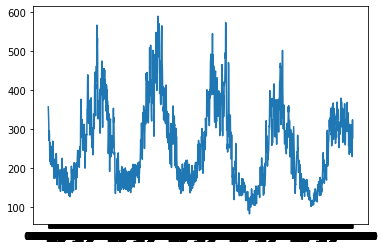

In [11]:
plt.plot(df.Date,df.Consumption)

# Data Features
Many techniques can help to identify the time series features. I chose to empoy EMD (Empirical Model Decomposition) to decompose the time series (signal) into several components, which are Intrict Model Functions (IMFs) and Residual. More details on the methodology can be found at https://royalsocietypublishing.org/doi/10.1098/rspa.1998.0193. This mehtodology works well on non-linear and non-stationary data. 

There have been several evolutions of the original ideas, with marjor improvement. I have used the Completed Complete ensemble EMD with adaptive noise (CEEMDAN). The package to perform it is https://pyemd.readthedocs.io/en/latest/intro.html#. I used the default parameters of the decomposition. 

One of the biggest features of EMD and its variants is the components are additive, and by summing up the components, the original signal can be reconstructed, and no information are lost. This property of the methodoloy allows de-noise and de-trend data. 

In [12]:
#conduct CEEMDAN with default paramters and maximum 7 IMFs
ceemdan = PyEMD.CEEMDAN()
cIMFs = ceemdan.ceemdan(np.array(df.Consumption))

In [13]:
#Seperate IMFs and Residual from the results
imfs, res = ceemdan.get_imfs_and_residue()

The figures below show the IMFs and residual, which is a monotonic trend. Each IMF can be viewed as a cycle with different length. It is common that the lower order IMFs (i.e., IMF 1, IMF2, etc) are pure noise, by removing which effectively de-noised the underlying data and protentially provent overfitting when creating the model for forecast. 

There are statistical significance tests that test the hypothese that the lower order IMFs are indifferent to noise. In this exercise, I am going to assume IMF1 and IMF2 are noises, thus discard from the original data. Therefore, the forecast model is created based on the modified data by removing IMF1 and IMF2. 

Based on the decomposition, the consumption data shows an overall decreasing trend and seasonality, which will impact on the choice of models.

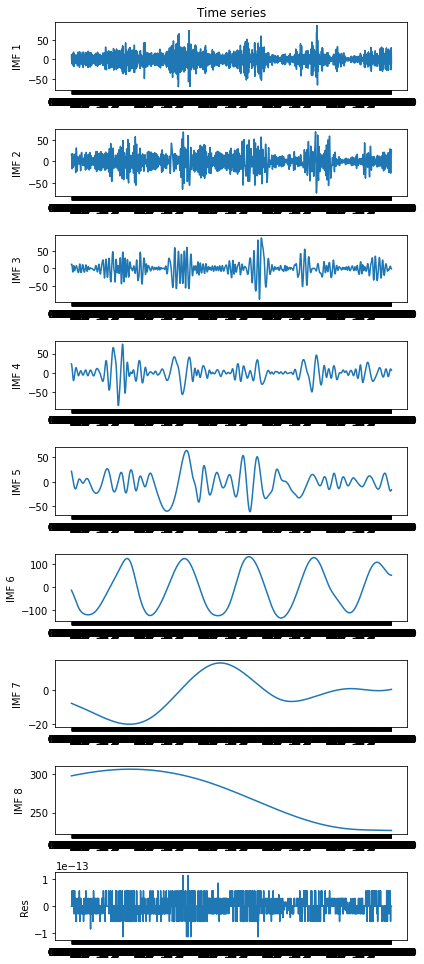

In [14]:
#plot the results 
vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue = res, t=df.Date, include_residue=True)
vis.show()

In [15]:
#create a new dataframe for the model that contains the de-noised data by removing IMF1 and IMF2
imfs_df = pd.DataFrame(imfs)
#imfs_df_t = imfs_df.T

mod_df = pd.DataFrame()
mod_df['Consumption'] = imfs_df.iloc[2:8].sum()
mod_df['Date'] = df['Date']
mod_df.head()

,Consumption,Date
0,331.405864,01-Apr-15
1,327.857308,02-Apr-15
2,321.215575,03-Apr-15
3,311.815359,04-Apr-15
4,300.007654,05-Apr-15


Below is the comparison between the original time series and the de-noised one, the de-noised one will be used for creating the model for forecast in the next section. 

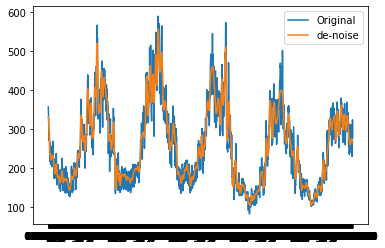

In [16]:
#compare the impact of de-noise by plotting both data on the same figure
plt.plot(df.Date,df.Consumption,label='Original')
plt.plot(mod_df.Date,mod_df.Consumption,label='de-noise')
plt.legend()
plt.show()

Test stationarity of the data using Augmented Dickey-Fuller test, the p-value is just over 5%, which implies at 10% siginificant level, we can reject the null hypotheis that the time series is non-stationary. Hence, no further transformation required to make the data stationary. 

In [17]:
#test for stationarity 
ad_fuller_result = adfuller(mod_df['Consumption'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8502793514594393
p-value: 0.051442869334643024


# Forecast Model
Since the data exhibits seasonality and trend, therefore a model can deal with trend and seasonality is the most appropriate. Among the choices, Exponential Holt-Winters Exponential Smoothing and Seasonal ARIMA are the most popular ones. 

I have experimented with both, it noted that SARIMA is computation expensive given the season period we have in this problem. A daily data for a season period of 12-month. Hence, the modelling choice is Exponential Smoothing with additive seasonality as seen in the decomposition above. 


In [18]:
mod_df['Date'] = pd.to_datetime(mod_df['Date'])

In [19]:
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Consumption  1827 non-null   float64       
 1   Date         1827 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.8 KB


Data is split into training and testing data, where the last year of daily data is for testing, and the rest will be used for training the model. 

In [21]:
train_df = mod_df.iloc[0:1827-365]
test_df = mod_df.tail(365)

In [32]:
model_ES = ExponentialSmoothing(train_df['Consumption'], seasonal='add', seasonal_periods=365).fit()

In [33]:
pred_df = model_ES.forecast(steps=365)

Below shows the comparison between the forecast for the next 12-month period and the actuals. The accuracy is meansured by Rooted Mean Square Error (RMSE).

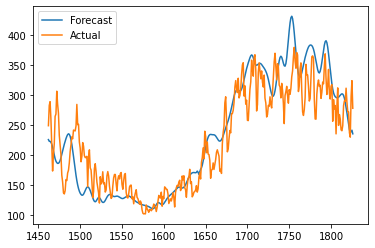

In [44]:
plt.plot(pred_df,label='Forecast')
plt.plot(df['Consumption'].tail(365),label='Actual')
plt.legend()
plt.show()

In [45]:
#calculate RMSE
np.round(np.sqrt(((pred_df-df['Consumption'].tail(365))**2).mean()),2)

42.74

In [52]:
#save model object for forecast
with open("energy_demand_forecast_md.pkl","wb") as f:
    pickle.dump(model_ES,f)

# Forecast
Create forecast for the next 12-month period based on the model object. 

In [ ]:
#For forecast only, load model first 
#model_ES = pd.read_pickle('energy_demand_forecast_md.pkl')

In [41]:
pred_df_1y = model_ES.forecast(steps=365*2)

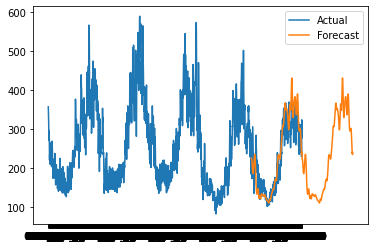

In [49]:
plt.plot(df['Date'],df['Consumption'],label='Actual')
plt.plot(pred_df_1y,label='Forecast')
plt.legend()
plt.show()